# Problem Set 1
### CUSP-GX.7003-001 Civic Analytics and Urban Intelligence
#### Nina Nurrahmawati | nn1221 | N10678470 
_________________________________________________________________

This assignment aims to prioritize service delivery for Heat/Hot Water services in New York City. The 311 data from 2010 until 2014 shows that heat/hot water problem become the most complained issue among other type of complaints received. New York City allows complaint regarding residential building that does not have enough heat only between October 1 and May 31 [(source)](http://www1.nyc.gov/site/hpd/owners/heat-hot-water.page), therefore this assignment will use data from October 1 to May 31.

## Objectives

The objective of this assignment will look at :

**1. Change in heat/hot water complaints during winter 2010 - 2016.**

Heating and hot water issues always occur every year, however it still has annual highest number of complaints. This phenomena indicate the current policy or services delivery is not adequate to prevent or minimize the problem. This objective will assess whether there is any change of pattern, which indicate any improvement efforts in solving heating problem.

**2. Correlation between heat/hot water complaints and gas consumption by zip code in 2010.** 

Residential in New York City uses heating oil and natural gas as source of heating. According to [NYC Clean Heat](https://www.nyccleanheat.org/content/what-nyc-clean-heat), NYC Department of Environmental Protection issued regulation that order buildings to convert heating oil to cleaner fuels, including natural gas. This objective will examine any correlation between number of heating complaints with gas consumption, whether location with higher gas consumption has more complaints or vice versa.

## Data
1. Filtered [311 Service Requests from 2010 to Present](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) data from NYC Open Data. The data filtered by complaint type of heating and heat/hot water between October 1 and May 31, from 2010 - 2017. 
[(Filtered 311 data)](https://drive.google.com/file/d/0B_lQz9ed5TcsRTBucGI2OE8tZE0/view?usp=sharing)
2. [Natural Gas Consumption by Zip Code - 2010](https://data.cityofnewyork.us/Environment/Natural-Gas-Consumption-by-ZIP-Code-2010/uedp-fegm). 

## Method
The data are analyzed using QGIS for visualization and Python for descriptive analysis and regression analysis.

In [343]:
from __future__ import print_function
import pandas as pd
import numpy as np
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
import statsmodels.formula.api as smf
import scipy.stats as st

In [155]:
# import data
data = pd.read_csv('311_HEAT.csv')
data.columns = ['Date', 'Frequency', 'Zipcode', 'Borough', 'Latitude', 'Longitude', 'Location']

In [156]:
# eliminate all zip code outside NYC and change to integer
data = data[data['Zipcode'] < 12000 ]
data['Zipcode'] = data.Zipcode.astype(int)

In [157]:
# set datetime
data['Date'] = data['Date'].str[:19]
data['Date'] = pd.to_datetime(data.Date)
data['Year'] = data['Date'].dt.strftime('%Y')
data['YearMonth'] = data['Date'].dt.strftime('%Y/%m')
data['Month'] = data['Date'].dt.strftime('%b')

In [233]:
# create new dataframe
winter2016 = data[(data['Date']>dt.date(2016,10,1)) & (data['Date']<dt.date(2017,5,31))]
winter2015 = data[(data['Date']>dt.date(2015,10,1)) & (data['Date']<dt.date(2016,5,31))]
winter2014 = data[(data['Date']>dt.date(2014,10,1)) & (data['Date']<dt.date(2015,5,31))] 
winter2013 = data[(data['Date']>dt.date(2013,10,1)) & (data['Date']<dt.date(2014,5,31))] 
winter2012 = data[(data['Date']>dt.date(2012,10,1)) & (data['Date']<dt.date(2013,5,31))] 
winter2011 = data[(data['Date']>dt.date(2011,10,1)) & (data['Date']<dt.date(2012,5,31))] 
winter2010 = data[(data['Date']>dt.date(2010,10,1)) & (data['Date']<dt.date(2011,5,31))] 

df16 = winter2016.groupby(['Zipcode']).size().reset_index()
df15 = winter2015.groupby(['Zipcode']).size().reset_index()
df14 = winter2014.groupby(['Zipcode']).size().reset_index()
df13 = winter2013.groupby(['Zipcode']).size().reset_index()
df12 = winter2012.groupby(['Zipcode']).size().reset_index()
df11 = winter2011.groupby(['Zipcode']).size().reset_index()
df10 = winter2010.groupby(['Zipcode']).size().reset_index()

m1 = pd.merge(df10, df11, on='Zipcode', how='inner') 
m2 = pd.merge(df12, df13, on='Zipcode', how='inner') 
m3 = pd.merge(df14, df15, on='Zipcode', how='inner') 
m4 = pd.merge(m1, m2, on='Zipcode', how='inner') 
m5 = pd.merge(m3, df16, on='Zipcode', how='inner') 

df = pd.merge(m4, m5, on='Zipcode', how='inner') 
df.columns = ['Zipcode', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
# >> The data will be used for plotting in the map by zipcodes using QGIS
# df.to_csv('Heat.csv') 
# preview of data
# df.head(3 ) 

In [234]:
Total = df.drop(['Zipcode'], axis=1)
Total = Total.sum().reset_index()
Total.columns = ['Winter Year', 'Total Complaints']
Total = Total.T
Total.columns = range(2010,2017)
Total = Total.T

In [235]:
# import gas consumption
gas = pd.read_csv('https://data.cityofnewyork.us/api/views/uedp-fegm/rows.csv?accessType=DOWNLOAD')

# change zip code type to integer
gas['Zip Code'] = gas['Zip Code'].str[:5]
gas['Zip Code'] = gas['Zip Code'].astype(int)

# filter only residential
gas = gas[gas['Building type (service class']!= 'Commercial']
gas = gas[gas['Building type (service class']!= 'Institutional']
gas = gas[gas['Building type (service class']!= 'Industrial']

In [236]:
gascon = gas.groupby(['Zip Code'])[' Consumption (therms) '].sum().reset_index()
gascon.columns = ['Zipcode', 'Consumption']

In [239]:
df2 = pd.merge(gascon, df, on='Zipcode', how='inner') 

In [243]:
# Drop all 0 values and NaN values, for regression analysis
df2 = df2[df2!=0]
df2 = df2.dropna()

Function for visualization and descriptive statistics

In [302]:
# Visualization total complaints
def plottotal():
    Total.plot(kind='bar', figsize=(7, 3), label='Heating Complaints Winter').legend()
    plt.title('Total Heating Complaints', fontsize=20)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel('No of Complaints', fontsize = 15)

In [300]:
# Visualization monthly complaints
def plottrend():
    plt.subplot(1, 1, 1)
    plt.title('Heating Complaints\n(per month)', fontsize=20)
    winter2010.groupby(['YearMonth']).size().plot(figsize=(10, 5), label='Winter 2010').legend()
    plt.ylabel('Complaints', fontsize = 10)
    plt.subplot(1, 1, 1)
    winter2011.groupby(['YearMonth']).size().plot(figsize=(10, 5), label='Winter 2011').legend()
    plt.ylabel('Complaints', fontsize = 10)
    plt.subplot(1, 1, 1)
    winter2012.groupby(['YearMonth']).size().plot(figsize=(10, 5), label='Winter 2012').legend()
    plt.ylabel('Complaints', fontsize = 10)
    plt.subplot(1, 1, 1)
    winter2013.groupby(['YearMonth']).size().plot(figsize=(10, 5), label='Winter 2013').legend()
    plt.ylabel('Complaints', fontsize = 10)
    plt.subplot(1, 1, 1)
    winter2014.groupby(['YearMonth']).size().plot(figsize=(10, 5), label='Winter 2014').legend()
    plt.ylabel('Complaints', fontsize = 10)
    plt.subplot(1, 1, 1)
    winter2015.groupby(['YearMonth']).size().plot(figsize=(10, 5), label='Winter 2015').legend()
    plt.ylabel('Complaints', fontsize = 10)
    plt.subplot(1, 1, 1)
    winter2016.groupby(['YearMonth']).size().plot(figsize=(10, 5), label='Winter 2016').legend()
    plt.xlabel('Month', fontsize = 10)
    plt.ylabel('Complaints', fontsize = 10)
    plt.tight_layout()

In [313]:
def gasheat2010():
    plt.title('Year 2010', fontsize=15)
    plt.scatter(df2.Consumption,df2['2010'], color='c', alpha=0.5, label='2010')
    plt.xlabel('Gas Consumption')
    plt.ylabel('Number of Complaints')
    plt.tight_layout()

In [386]:
def gasheat():
    fig, ax = plt.subplots()
    plt.title('Year 2010-2016', fontsize=15)
    ax.scatter(df2.Consumption,df2['2010'], color='c', alpha=0.1, label='2010')
    ax.scatter(df2.Consumption,df2['2011'], color='m', alpha=0.1, label='2011')
    ax.scatter(df2.Consumption,df2['2012'], color='y', alpha=0.1, label='2012')
    ax.scatter(df2.Consumption,df2['2013'], color='k', alpha=0.1, label='2013')
    ax.scatter(df2.Consumption,df2['2014'], color='r', alpha=0.1, label='2014')
    ax.scatter(df2.Consumption,df2['2015'], color='g', alpha=0.1, label='2015')
    ax.scatter(df2.Consumption,df2['2016'], color='b', alpha=0.1, label='2016')
    plt.xlabel('Gas Consumption (therms)')
    plt.ylabel('Number of Complaints')
    ax.legend()
    plt.tight_layout()

Function for analysis

In [335]:
def dataztest():
    mean2010 = df['2010'].mean()
    std2010 = df['2010'].std()
    mean2016 = df['2016'].mean()
    std2016 = df['2016'].std()

    print ('2010 Mean : {:.2f}, \n2010 Standard Deviation : {:.2f} \n2016 Mean : {:.2f}, \n2016 Standard Deviation : {:.2f}'.format(mean2010, std2010, mean2016, std2016))

In [349]:
def z():
    z = (mean2010 - mean2016)/(std2010/np.sqrt(len(df)))
    print ("Z value = {:.3f}".format (z))
    zcritical = st.norm.ppf(.95)
    print ("Z value when p 0.95 = {:.3f}".format(zcritical))
    if z >= zcritical:
        print ("Null hypothesis is rejected, because z value >= z critical")
    else:
        print ("Null hypothesis is accepted, because z value < z critical")

In [374]:
def ols():
    df2.columns = ['zipcode', 'consumption', 'winter2010', 'winter2011', 'winter2012', 'winter2013', 'winter2014', 'winter2015', 'winter2016']
    lm = smf.ols(formula='winter2010 ~ consumption', data = df2).fit()
    print (lm.summary())

In [383]:
def viz():
    df2.plot(kind='scatter',x='consumption',y='winter2010', alpha=0.5, color='c')
    plt.plot(df2.consumption,lm.predict(),'r-')
    plt.title('Linear Model')
    plt.xlabel('Gas Consumption')
    plt.ylabel('Heating Complaints')
    plt.show()

## Descriptive Statistics

In [311]:
df.drop(['Zipcode'], axis=1).describe()

,2010,2011,2012,2013,2014,2015,2016
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,1201.034286,968.434286,1046.354286,1212.085714,1314.725714,1141.245714,1135.400000
std,1428.570964,1170.106644,1267.320846,1567.570871,1612.671060,1360.289106,1358.891688
min,1.000000,1.000000,2.000000,5.000000,5.000000,5.000000,2.000000
25%,245.000000,185.000000,202.500000,198.000000,211.500000,186.000000,179.000000
50%,664.000000,531.000000,536.000000,625.000000,710.000000,644.000000,589.000000
75%,1504.000000,1246.500000,1381.000000,1442.000000,1686.500000,1510.500000,1471.000000
max,6917.000000,5710.000000,5747.000000,8260.000000,7721.000000,6319.000000,6942.000000


**Table 1. Descriptive Statistics**

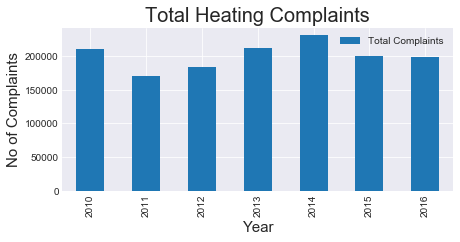

In [303]:
plottotal()

**Table 2. Total Heating/Hot Water Complaints**

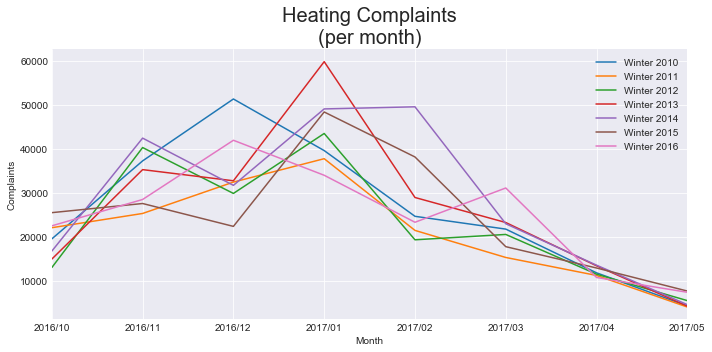

In [326]:
plottrend()

**Figure 1. Trends in the number of heating complaints**

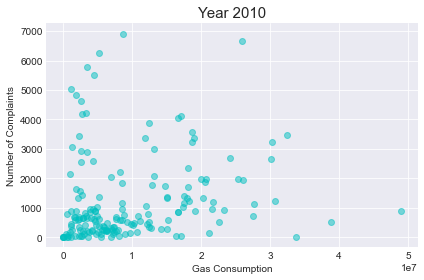

In [314]:
gasheat2010()

**Figure 2. Scatterplot of Gas Consumption and Number of Heating Complaints in 2010**

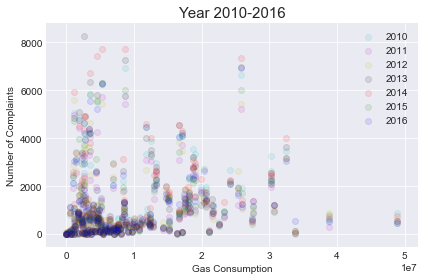

In [318]:
gasheat()

**Figure 3. Scatterplot of Gas Consumption and Number of Heating Complaints during 2010-2016**

## Visualization
Visualization of complaints during Oct 1 - May 31
map the locations of 311 complaints for the specific type you have chosen.

![](https://raw.githubusercontent.com/ninanrh/CAUI/master/img/1.png)
![](https://raw.githubusercontent.com/ninanrh/CAUI/master/img/2.png)
**Figure 4. Scatterplot of Gas Consumption and Number of Heating Complaints during 2010-2016**

## Analysis
There are 2 part of analysis that I conduct. The first one looks at the change in heating complaints from winter 2010 to winter 2016. The second one attempts to see the correlation and linear regression model between number of heating complaints and gas consumption.

**1. Change in heat/hot water complaints**

This analysis uses Z test with the significance level of 0.05.

Null Hypothesis:

H$_0$: The mean of the number of complaints in winter 2016 is the same or greater than the number of complaints in 2010.

H$_0$ : C$_{2016} \geq$ C$_{2010}$

Alternative Hypothesis:

H$_1$: The mean of the number of complaints in winter 2016 is the same or lower than the number of complaints in 2010

H$_1$: C$_{2016}$ < C$_{2010}$

In [351]:
# Data
dataztest()

2010 Mean : 1201.03, 
2010 Standard Deviation : 1428.57 
2016 Mean : 1135.40, 
2016 Standard Deviation : 1358.89


In [352]:
# Z-test
z()

Z value = 0.608
Z value when p 0.95 = 1.645
Null hypothesis is accepted, because z value < z critical


Result from z test above shows that null hypothesis is accepted. That means there is no improvement in solving heating problems in 2016 compare to 2010.

**2. Correlation between number of heating complaints and gas consumption**

This part will examine correlation between number of heating complaints and gas consumption and estimate the linear model of :

$y=w_1*x+w_0$

where 

$y$ = heating complaints (2010)

$x$ = gas consumption (2010)

In [353]:
# Correlation test (R Pearson)
df2.drop('Zipcode', axis=1).corr()

,Consumption,2010,2011,2012,2013,2014,2015,2016
Consumption,1.000000,0.170487,0.149707,0.135335,0.095968,0.123109,0.122538,0.146365
2010,0.170487,1.000000,0.987713,0.975929,0.951970,0.976487,0.968909,0.967056
2011,0.149707,0.987713,1.000000,0.981203,0.950280,0.978455,0.970269,0.962347
2012,0.135335,0.975929,0.981203,1.000000,0.956635,0.976924,0.966091,0.952631
2013,0.095968,0.951970,0.950280,0.956635,1.000000,0.966245,0.950190,0.948920
2014,0.123109,0.976487,0.978455,0.976924,0.966245,1.000000,0.983058,0.972954
2015,0.122538,0.968909,0.970269,0.966091,0.950190,0.983058,1.000000,0.983019
2016,0.146365,0.967056,0.962347,0.952631,0.948920,0.972954,0.983019,1.000000


In [363]:
df2.describe()

,Zipcode,Consumption,2010,2011,2012,2013,2014,2015,2016
count,173.000000,1.730000e+02,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,10815.034682,9.553132e+06,1214.895954,979.595376,1058.404624,1225.953757,1329.763006,1154.289017,1148.502890
std,575.069449,8.703332e+06,1430.955934,1172.222952,1269.644786,1571.281235,1615.873814,1362.691978,1361.230589
min,10001.000000,1.767700e+04,5.000000,1.000000,10.000000,5.000000,5.000000,5.000000,7.000000
25%,10303.000000,2.897767e+06,247.000000,186.000000,205.000000,200.000000,228.000000,197.000000,190.000000
50%,11201.000000,6.444029e+06,674.000000,532.000000,539.000000,625.000000,735.000000,651.000000,598.000000
75%,11361.000000,1.474391e+07,1580.000000,1251.000000,1408.000000,1456.000000,1724.000000,1517.000000,1488.000000
max,11694.000000,4.892323e+07,6917.000000,5710.000000,5747.000000,8260.000000,7721.000000,6319.000000,6942.000000


In [377]:
ols()

                            OLS Regression Results                            
Dep. Variable:             winter2010   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     5.119
Date:                Mon, 09 Oct 2017   Prob (F-statistic):             0.0249
Time:                        21:46:08   Log-Likelihood:                -1499.5
No. Observations:                 173   AIC:                             3003.
Df Residuals:                     171   BIC:                             3009.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     947.1164    159.897      5.923      

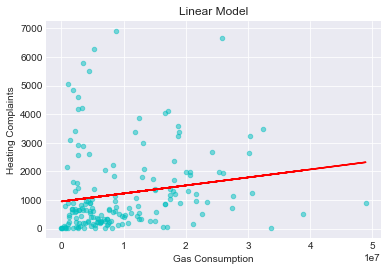

In [385]:
viz()

## Discussion
> Describe how an agency might use your findings to improve service delivery or performance. What agency(ies) would be involved? What are the limitations of your approach? What could you do to improve it?